<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Clasificación y localización de objetos<a id="top"></a>

<i><small>Última actualización: 2024-02-25</small></i></div>
***

## Introducción

Vamos a introducir algunos conceptos básicos sobre la detección de objetos. En este notebook nos centraremos en explicar cómo se comporta un modelo de clasificación y localización de un único objeto.

Para ello utilizaremos un modelo de red neuronal convolucional (CNN) que, tras su capa de convolución, se dividirá en dos ramas: una destinada a la clasificación del objeto y la otra a la de la identificación del _bounding box_ que lo contiene.

## Objetivos

Trataremos de:

- Familiarizarnos con el proceso de creación, entrenamiento y evaluación de un modelo de clasificación más localización de objetos,
- Implementar una red convolucional que se bifurca en dos partes después de la capa de convolución para realizar tanto la clasificación como la localización de objetos en imágenes, y
- Evaluar el rendimiento del modelo utilizando métricas apropiadas para clasificación y localización.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del _notebook_.

In [1]:
import io
import urllib
import zipfile

from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2024-02-27 16:59:10.865216: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 16:59:10.868013: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 16:59:10.898015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 16:59:11.430607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Y vamos a configurar el formato de salida de numpy y matplotlib.

In [71]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})
plt.style.use('ggplot')

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

***

## Conjunto de datos sobre el que trabajar

Vamos a trabajar con un conjunto de datos descargado de [roboflow](https://roboflow.com/), concretamente el [_6 Sided Dice Dataset_](https://public.roboflow.com/object-detection/dice/) que consiste en un montón de fotografías de datos de seis caras en diferentes situaciones. Comenzaremos descargando y descomprimiendo el conjunto de datos.

In [3]:
url = 'https://public.roboflow.com/ds/KhrcQlJSa4?key=SavDbGzen4'
dataset_dir = 'datasets/6-sided-dice'

zip_file = urllib.request.urlopen(url)
with zipfile.ZipFile(io.BytesIO(zip_file.read())) as f:
    f.extractall(dataset_dir)

Veamos ahora qué forma tiene el conjunto de datos descargado.

In [4]:
df = pd.read_csv(dataset_dir + '/export/_annotations.csv')
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cZ2myTfL1FPj82zLx3wS.jpg,756,1008,2,512,591,528,610
1,cZ2myTfL1FPj82zLx3wS.jpg,756,1008,5,482,569,498,587
2,i.rf.caf0ed1eabaca59e25fd56bcf0613fa5.jpg,756,1008,3,369,400,394,420
3,IMG_0724_jpeg.rf.cf2f1dc7a223309ad26b0826a825e...,756,1008,3,473,582,489,599
4,IMG_0724_jpeg.rf.cf2f1dc7a223309ad26b0826a825e...,756,1008,1,463,561,480,579
...,...,...,...,...,...,...,...,...
1929,cQNMpHnwESng7ksObfjc.jpg,756,1008,6,433,415,480,448
1930,cXIgZQm7PNOuVPXa5fub.jpg,756,1008,6,470,331,496,350
1931,cXIgZQm7PNOuVPXa5fub.jpg,756,1008,6,222,530,251,556
1932,cXmM2ph2RKqW6g4iBE5Y.jpg,756,1008,6,634,609,653,628


Podemos observar que se compone de las siguientes columnas:

- `filename`: El nombre del fichero de imagen al que hace referencia,
- `width` y `height`: Las dimensiones de la imagen,
- `class`: La clase a la que pertenece el dado capturado, y
- `xmin`, `ymin`, `xmax` e `ymax`: Las coordenadas del _bounding box_ del dado en la imagen.

También se observa que aparecen varias entradas diferentes para la misma imagen. Esto es debido a que en algunas imágenes existe más de un dado, por lo que cada fila es un bounding box haciendo referencia a un único dado.

Para nuestro problema, no obstante, usaremos aquellas imágenes que contengan un único dado, por lo que vamos a procesar el conjunto de datos.

In [5]:
count = df['filename'].value_counts()
just_one_class_indexes = count[count == 1].index
df = df[df['filename'].isin(just_one_class_indexes)]
df.shape

(296, 8)

Bueno, nos quedamos únicamente con 296 ejemplos. Aun así, es suficiente para el ejemplo que nos ocupa. Antes de proseguir con el modelo, vamos a preprocesar este conjuntos de datos.

Comenzaremos con eliminar las columnas de width y height ya que tienen el mismo valor para todos los ejemplos.

In [6]:
WIDTH, HEIGHT = 756, 1008
TARGET_W, TARGET_H = 189, 252
df = df[['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']]

También convertiremos los nombres de las imágenes al nombre relativo desde el directorio de este notebook.

In [7]:
df['filename'] = dataset_dir + '/export/' + df['filename']

Tenemos que cambiar los valores de la columna `class` ya que para el modelo los valores de salida los queremos de 0 a 5, no de 1 a 6.

In [8]:
df['class'] -= 1

Por último, normalizaremos los valores de las coordenadas de las _bounding boxes_ a $[0, 1]$ respecto al tamaño de la imagen.

In [9]:
df['xmin'] = df['xmin'] / WIDTH
df['xmax'] = df['xmax'] / WIDTH
df['ymin'] = df['ymin'] / HEIGHT
df['ymax'] = df['ymax'] / HEIGHT

El conjunto nos queda, pues, como sigue.

In [10]:
df

,filename,class,xmin,ymin,xmax,ymax
2,datasets/6-sided-dice/export/i.rf.caf0ed1eabac...,2,0.488095,0.396825,0.521164,0.416667
5,datasets/6-sided-dice/export/i.rf.ceef8dedd962...,0,0.481481,0.392857,0.525132,0.418651
6,datasets/6-sided-dice/export/i.rf.cb728c4974c6...,4,0.425926,0.375992,0.554233,0.451389
9,datasets/6-sided-dice/export/i.rf.ccbe86b2ce6a...,0,0.493386,0.312500,0.567460,0.352183
12,datasets/6-sided-dice/export/i.rf.cceec6bb69a6...,2,0.376984,0.344246,0.554233,0.453373
...,...,...,...,...,...,...
1900,datasets/6-sided-dice/export/i.rf.c2f09fef54b0...,5,0.464286,0.424603,0.609788,0.534722
1903,datasets/6-sided-dice/export/i.rf.c3e7320d4e1f...,3,0.490741,0.381944,0.578042,0.432540
1923,datasets/6-sided-dice/export/i.rf.c7ccb7799a28...,1,0.437831,0.385913,0.579365,0.470238
1924,datasets/6-sided-dice/export/i.rf.c7f14ea557dc...,1,0.432540,0.267857,0.481481,0.300595


Ahora lo dividiremos en conjuntos de entrenamiento y test, cada uno con sus entradas (`x_train`, `x_test`) y salidas (`y_train`, `y_test`) correspondientes.

In [11]:
# Separamos aleatoriamente un 80/20 para train y test resp.
trn_df = df.sample(frac=0.8,random_state=42)
tst_df = df.drop(trn_df.index)

# Obtenemos las entradas y salidas para el modelo
x_train, x_test = trn_df.to_numpy()[:,0], tst_df.to_numpy()[:,0]
y_train, y_test = trn_df.to_numpy()[:,1:].astype('float32'), tst_df.to_numpy()[:,1:].astype('float32')

Al tratarse de un conjunto de datos pequeños, podemos cargar todas las imágenes en memoria. Un conjunto de datos más grande requeriría el uso de otras técnicas, como por ejemplo el uso de [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Comencemos creando una función para cargar la imagen en un array de NumPy.

In [12]:
def load_image(path, target_size=None):
    """Carga una imagen y la convierte en un array de NumPy.

    :param path: Ruta al archivo de la imagen
    :param target_size: Reescalado de la imagen (W, H). Si no se especifica, no hay reescalado
    :return: El array con la imagen
    """
    with Image.open(path) as img:
        if target_size:
            img = img.resize(target_size)
        return np.array(img)

Y tras esto actualizamos los valores de entrada de los conjuntos de entrenamiento (`x_train`) y test (`x_test`). Como sus valores van de 0 a 255, los normalizaremos al intervalo $[0, 1]$

In [13]:
x_train = np.array([load_image(path, target_size=(TARGET_H, TARGET_W)) for path in x_train]).astype('float32')
x_test = np.array([load_image(path, target_size=(TARGET_H, TARGET_W)) for path in x_test]).astype('float32')

x_train = x_train / 255
x_test = x_test / 255

Por último, comprobamos la estructura de los conjuntos de entrenamiento y test.

In [14]:
print(f'Training shape: Input -> {x_train.shape}, Output {y_train.shape}')
print(f'Test shape:     Input -> {x_test.shape},  Output {y_test.shape}')

Training shape: Input -> (237, 189, 252, 3), Output (237, 5)
Test shape:     Input -> (59, 189, 252, 3),  Output (59, 5)


## Construcción del modelo

Vamos a usar el API funcional de keras para crear el modelo. Como se trata de una clasificación más una localización, usaremos un primer bloque común compuesto de capas convolucionales para extraer las características de la imagen y luego, con esas características, especializaremos dos modelos diferentes, uno para realizar una clasificación y otro para realizar una regresión de las coordenadas del _bounding box_.

In [73]:
# Entrada del modelo
input_img = tf.keras.layers.Input(shape=(TARGET_W, TARGET_H, 3))

# Bloque convolucional
output = tf.keras.layers.Conv2D(filters=32,
                                kernel_size=(3, 3),
                                activation='relu'
                               )(input_img)

output = tf.keras.layers.Flatten()(output)

# Rama de clasificación
classification_output = tf.keras.layers.Dense(6, activation='softmax')(output)

# Rama de localización
localization_output = tf.keras.layers.Dense(4, activation='sigmoid')(output)

# Ahora definimos el modelo a partir de sus entradas y salidas
model = tf.keras.Model(inputs=input_img, outputs=[classification_output, localization_output])

# Y lo compilamos, especificando cuál será la función de pérdida de cada rama
model.compile(optimizer='adam',
              loss=['sparse_categorical_crossentropy', 'mse'],
              metrics=['accuracy', 'mse']
             )

Con el modelo creado, ya sólo nos queda entrenar.

In [74]:
history = model.fit(
    x_train, [y_train[:,0], y_train[:,1:]],
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - dense_8_accuracy: 0.1516 - dense_9_mse: 0.1489 - loss: 135.8273 - val_dense_8_accuracy: 0.2083 - val_dense_9_mse: 0.2170 - val_loss: 107.4960
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - dense_8_accuracy: 0.1210 - dense_9_mse: 0.2203 - loss: 116.4740 - val_dense_8_accuracy: 0.1667 - val_dense_9_mse: 0.2170 - val_loss: 73.8544
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - dense_8_accuracy: 0.1764 - dense_9_mse: 0.2213 - loss: 58.6229 - val_dense_8_accuracy: 0.1667 - val_dense_9_mse: 0.2170 - val_loss: 16.4557
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - dense_8_accuracy: 0.1569 - dense_9_mse: 0.2198 - loss: 15.0470 - val_dense_8_accuracy: 0.0417 - val_dense_9_mse: 0.2170 - val_loss: 7.6787
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - dense_8_accuracy: 0.3159 - dense_9_mse: 0.2195 - loss: 3.9576 - val_dense_8_accuracy: 0.3333 - val_dense_9_mse: 0.2170 - val_loss: 2.1603
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 3

Así de primeras parece un entrenamiento con pocos _epochs_, por lo cual no deberíamos esperar mucho de él. Aun así, veamos qué tal lo ha hecho en este pequeño lapso de tiempo.

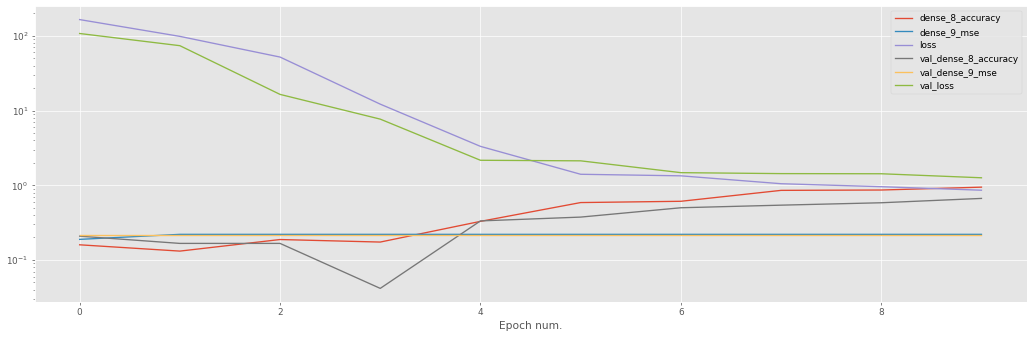

In [75]:
pd.DataFrame(history.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

Parece que ha aprendido algo. Veamos cómo se comporta con datos que no ha visto nunca. Para ello, crearemos una función que imprimirá la imagen, la clase clasificada y el _bounding box_ en el que ha localizado el dado.

In [76]:
def plot_images_with_predictions(images, predictions, ncols=4):
    """Pinta la imágenes, el bbox y el número que ha salido en el dado.
    
    :param images: El array de las imágenes
    :param predictions: Una lista con dos elementos, (1) las predicciones de
        clasificación (en one-hot), y (2) las coordenadas de las bounding
        boxes
    :param: Número de imágenes por columna (4 en caso de no especificarse)
    """
    # Número de imágenes
    n = len(images)
    # Número de columnas calculado en base a nrows
    nrows = int(np.ceil(len(images) / ncols))
    
    # Tamaño de la figura
    plt.figure(figsize=(ncols*6, nrows*6))

    for i in range(n):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i])

        # Decodificar la clase (sumo 1 porque el dado es de 1 a 6 el dado)
        class_pred = np.argmax(predictions[0][i]) + 1

        # Extraer las coordenadas de la bounding box
        xmin, ymin, xmax, ymax = predictions[1][i]

        # Desnormalizamos
        height, width, _ = images[i].shape
        xmin *= width
        xmax *= width
        ymin *= height
        ymax *= height

        # Crear un rectángulo para la bounding box
        rect = patches.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            linewidth=1, edgecolor='r',
            facecolor='none',
        )

        # Imprimimos el título
        plt.title(f'Clase: {class_pred}\nbbox = ({xmin:.2f},{ymin:.2f},{xmax:.2f},{ymax:.2f})')
        
        # Añadir el rectángulo a la imagen
        plt.gca().add_patch(rect)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

Y ahora predecimos el conjunto de test y comprobamos qué tal lo ha hecho.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


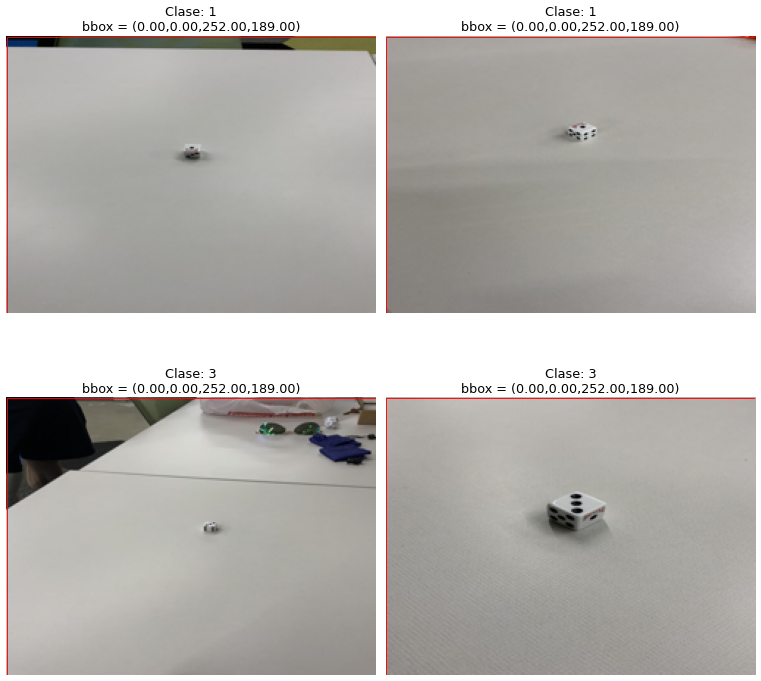

In [77]:
predictions = model.predict(x_test)

plot_images_with_predictions(x_test[:4], predictions[:4], ncols=2)
#plot_images_with_predictions(x_test[:4], [y_test[:4][:,0], y_test[:4][:,1:]], ncols=2)

## Conclusiones

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>